In [1]:
## library import
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt
import os

print(tf.__version__)
print(keras.__version__)

2.3.0
2.4.0


# RNN을 이용하여 MNIST Classification 학습하기 
  

MNIST Image를 한 line씩 RNN에 입력하여 classification을 하는 실습을 해보겠습니다.

In [2]:
## Hyper-parameters
learning_rate = 0.001
N_EPOCHS = 20
N_BATCH = 100
N_CLASS = 10

In [3]:
## Data 준비
## MNIST Dataset #########################################################
mnist = keras.datasets.mnist
class_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
##########################################################################

## Fashion MNIST Dataset #################################################
#mnist = keras.datasets.fashion_mnist
#class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
##########################################################################

In [4]:
## Dataset 만들기
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

N_TRAIN = train_images.shape[0]
N_TEST = test_images.shape[0]
print(train_images.shape, test_images.shape)

11493376/11490434 [==============================] - 0s 0us/step
(60000, 28, 28) (10000, 28, 28)


In [5]:
# pixel값을 0~1사이 범위로 조정
train_images = train_images.astype(np.float32) / 255.
test_images = test_images.astype(np.float32) / 255.

# label을 onehot-encoding
train_labels = to_categorical(train_labels, 10)
test_labels = to_categorical(test_labels, 10)    

# Dataset 구성
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels)).shuffle(
                buffer_size=100000).batch(N_BATCH).repeat()
test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels)).batch(N_BATCH)

In [6]:
## Model 만들기
def create_model():
    model = keras.Sequential()
    model.add(layers.LSTM(units=256, return_sequences=False, input_shape=(28,28)))
    model.add(layers.Dense(units=10, activation='softmax'))
    return model

In [7]:
## Create model, compile & summary
model = create_model()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 256)               291840    
_________________________________________________________________
dense (Dense)                (None, 10)                2570      
Total params: 294,410
Trainable params: 294,410
Non-trainable params: 0
_________________________________________________________________


In [8]:
## 학습 전에 결과 확인
model.evaluate(test_dataset)

100/100 [==============================] - 0s 3ms/step - loss: 2.3060 - accuracy: 0.0825


[2.306039571762085, 0.08250000327825546]

In [9]:
## Parameters for training
steps_per_epoch = N_TRAIN//N_BATCH
validation_steps = N_TEST//N_BATCH
print(steps_per_epoch, validation_steps)

600 100


In [10]:
## Training
history = model.fit(train_dataset, epochs=N_EPOCHS, steps_per_epoch=steps_per_epoch, 
                    validation_data=test_dataset, validation_steps=validation_steps)

Epoch 1/20
600/600 [==============================] - 3s 5ms/step - loss: 0.4097 - accuracy: 0.8644 - val_loss: 0.1357 - val_accuracy: 0.9564
Epoch 2/20
600/600 [==============================] - 3s 5ms/step - loss: 0.1190 - accuracy: 0.9637 - val_loss: 0.1096 - val_accuracy: 0.9668
Epoch 3/20
600/600 [==============================] - 3s 5ms/step - loss: 0.0810 - accuracy: 0.9750 - val_loss: 0.0728 - val_accuracy: 0.9787
Epoch 4/20
600/600 [==============================] - 3s 5ms/step - loss: 0.0594 - accuracy: 0.9820 - val_loss: 0.0743 - val_accuracy: 0.9752
Epoch 5/20
600/600 [==============================] - 3s 5ms/step - loss: 0.0517 - accuracy: 0.9835 - val_loss: 0.0581 - val_accuracy: 0.9811
Epoch 6/20
600/600 [==============================] - 3s 5ms/step - loss: 0.0392 - accuracy: 0.9883 - val_loss: 0.0532 - val_accuracy: 0.9837
Epoch 7/20
600/600 [==============================] - 3s 5ms/step - loss: 0.0372 - accuracy: 0.9885 - val_loss: 0.0464 - val_accuracy: 0.9857
Epoch 

In [11]:
## 결과 확인
def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(img,cmap=plt.cm.binary)

    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'

    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
    predictions_array, true_label = predictions_array[i], true_label[i]
    plt.grid(False)
    #plt.xticks([])
    plt.xticks(range(N_CLASS), class_names, rotation=90)
    plt.yticks([])
    thisplot = plt.bar(range(N_CLASS), predictions_array, color="#777777")
    plt.ylim([0, 1]) 
    predicted_label = np.argmax(predictions_array)
 
    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')

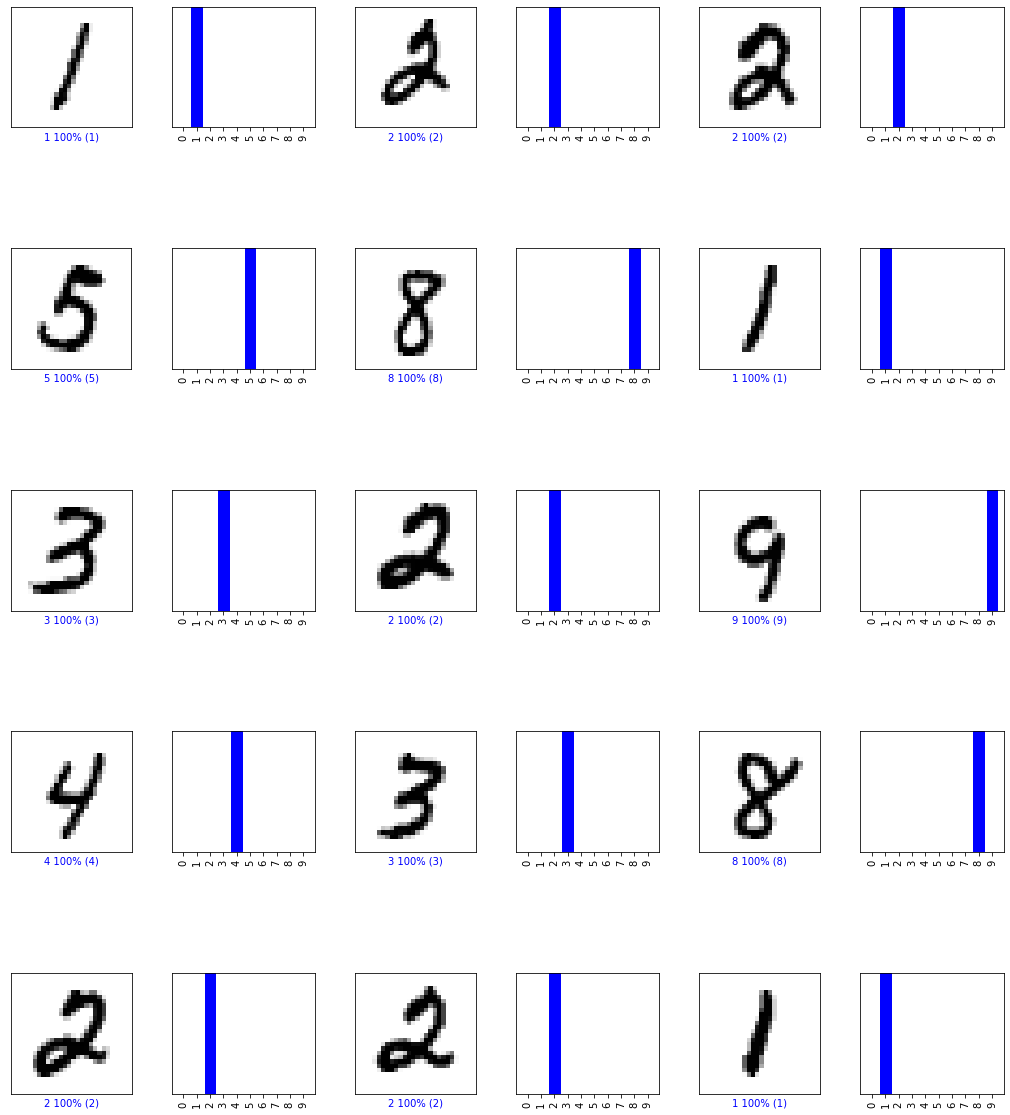

In [12]:
rnd_idx = np.random.randint(1, N_TEST//N_BATCH)
img_cnt = 0
for images, labels in test_dataset:
    img_cnt += 1
    if img_cnt != rnd_idx:
        continue
    predictions = model(images, training=False)
    num_rows = 5
    num_cols = 3
    num_images = num_rows*num_cols
    labels = tf.argmax(labels, axis=-1)
    plt.figure(figsize=(3*2*num_cols, 4*num_rows))
    plt.subplots_adjust(hspace=1.0)
    for i in range(num_images):
        plt.subplot(num_rows, 2*num_cols, 2*i+1)
        plot_image(i, predictions.numpy(), labels.numpy(), images.numpy())
        plt.subplot(num_rows, 2*num_cols, 2*i+2)
        plot_value_array(i, predictions.numpy(), labels.numpy())        
    break

# Simple Language Model with RNN

RNN을 이용하여 간단한 language model을 학습시켜 보겠습니다.

In [13]:
## 학습시킬 문장
sentence = ("if you want to build a ship, don't drum up people together to "
            "collect wood and don't assign them tasks and work, but rather "
            "teach them to long for the endless immensity of the sea.")

## index를 주면 charcter로 바꿔주는 list
idx2char = list(set(sentence))
## character를 주면 index로 바꿔주는 dictionary
char2idx = {w: i for i, w in enumerate(idx2char)}

In [14]:
idx2char, len(idx2char)

(['e',
  'o',
  'f',
  ' ',
  't',
  'y',
  'p',
  'r',
  "'",
  'a',
  ',',
  'i',
  'c',
  'g',
  'h',
  'w',
  'u',
  'k',
  'b',
  '.',
  's',
  'l',
  'm',
  'n',
  'd'],
 25)

In [15]:
char2idx

{' ': 3,
 "'": 8,
 ',': 10,
 '.': 19,
 'a': 9,
 'b': 18,
 'c': 12,
 'd': 24,
 'e': 0,
 'f': 2,
 'g': 13,
 'h': 14,
 'i': 11,
 'k': 17,
 'l': 21,
 'm': 22,
 'n': 23,
 'o': 1,
 'p': 6,
 'r': 7,
 's': 20,
 't': 4,
 'u': 16,
 'w': 15,
 'y': 5}

In [16]:
## HyperParameters
data_dim = len(idx2char)
hidden_size = len(idx2char)
num_classes = len(idx2char)
sequence_length = 10  # Any arbitrary number
learning_rate = 0.1
training_epochs = 200
print(num_classes)

25


In [17]:
## Dataset
dataX = []
dataY = []
for i in range(0, len(sentence) - sequence_length):
    x_str = sentence[i:i + sequence_length]
    y_str = sentence[i + 1: i + sequence_length + 1]
    print(i, x_str, '->', y_str)

    x = [char2idx[c] for c in x_str]  # x str to index
    y = [char2idx[c] for c in y_str]  # y str to index

    dataX.append(x)
    dataY.append(y)

batch_size = len(dataX)

0 if you wan -> f you want
1 f you want ->  you want 
2  you want  -> you want t
3 you want t -> ou want to
4 ou want to -> u want to 
5 u want to  ->  want to b
6  want to b -> want to bu
7 want to bu -> ant to bui
8 ant to bui -> nt to buil
9 nt to buil -> t to build
10 t to build ->  to build 
11  to build  -> to build a
12 to build a -> o build a 
13 o build a  ->  build a s
14  build a s -> build a sh
15 build a sh -> uild a shi
16 uild a shi -> ild a ship
17 ild a ship -> ld a ship,
18 ld a ship, -> d a ship, 
19 d a ship,  ->  a ship, d
20  a ship, d -> a ship, do
21 a ship, do ->  ship, don
22  ship, don -> ship, don'
23 ship, don' -> hip, don't
24 hip, don't -> ip, don't 
25 ip, don't  -> p, don't d
26 p, don't d -> , don't dr
27 , don't dr ->  don't dru
28  don't dru -> don't drum
29 don't drum -> on't drum 
30 on't drum  -> n't drum u
31 n't drum u -> 't drum up
32 't drum up -> t drum up 
33 t drum up  ->  drum up p
34  drum up p -> drum up pe
35 drum up pe -> rum up peo
36

In [18]:
dataX = np.array(to_categorical(dataX, num_classes))
dataY = np.array(to_categorical(dataY, num_classes))
print(dataX.shape, dataY.shape)
print(batch_size)

(170, 10, 25) (170, 10, 25)
170


In [19]:
train_dataset = tf.data.Dataset.from_tensor_slices((dataX, dataY)).shuffle(
                buffer_size=1000).batch(batch_size).repeat()

In [20]:
## Model 만들기
def create_model():
    model = keras.Sequential()
    model.add(layers.LSTM(units=hidden_size, return_sequences=True,
                                     input_shape=(dataX.shape[1],dataX.shape[2])))
    model.add(layers.LSTM(units=hidden_size, return_sequences=True))
    model.add(layers.Dense(units=num_classes, activation='softmax'))
    return model

In [21]:
model = create_model()
model.compile(optimizer=keras.optimizers.Adam(learning_rate),
              loss='categorical_crossentropy')
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 10, 25)            5100      
_________________________________________________________________
lstm_2 (LSTM)                (None, 10, 25)            5100      
_________________________________________________________________
dense_1 (Dense)              (None, 10, 25)            650       
Total params: 10,850
Trainable params: 10,850
Non-trainable params: 0
_________________________________________________________________


In [22]:
## Training
model.fit(train_dataset, epochs=training_epochs,
                    steps_per_epoch=dataX.shape[0]//batch_size)

Epoch 1/200
1/1 [==============================] - 0s 2ms/step - loss: 3.2153
Epoch 2/200
1/1 [==============================] - 0s 1ms/step - loss: 2.9851
Epoch 3/200
1/1 [==============================] - 0s 3ms/step - loss: 3.2243
Epoch 4/200
1/1 [==============================] - 0s 1ms/step - loss: 2.9092
Epoch 5/200
1/1 [==============================] - 0s 1ms/step - loss: 2.8864
Epoch 6/200
1/1 [==============================] - 0s 1ms/step - loss: 2.8488
Epoch 7/200
1/1 [==============================] - 0s 1ms/step - loss: 2.8449
Epoch 8/200
1/1 [==============================] - 0s 1ms/step - loss: 2.8462
Epoch 9/200
1/1 [==============================] - 0s 1ms/step - loss: 2.8355
Epoch 10/200
1/1 [==============================] - 0s 1ms/step - loss: 2.8169
Epoch 11/200
1/1 [==============================] - 0s 872us/step - loss: 2.7945
Epoch 12/200
1/1 [==============================] - 0s 802us/step - loss: 2.7663
Epoch 13/200
1/1 [==============================] - 0s 89

In [23]:
## 결과 확인
results = model.predict(dataX, steps=1)
for j, result in enumerate(results):
    index = np.argmax(result, axis=1)
    if j is 0:  # print all for the first result to make a sentence
        print(''.join([idx2char[t] for t in index]), end='')
    else:
        print(idx2char[index[-1]], end='')

f you want to build a ship, don't drum up people together to collect wood and don't assign them tasks and work, but rather teach them to long for the endless immensity of the sea.

# Stock Prediction with RNN  
RNN을 이용한 간단한 주식 예측 모델을 학습해보겠습니다.

In [ ]:
## google drive 연동
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [40]:
## HyperParameters
seq_length = 7
data_dim = 5
hidden_size = 10
output_dim = 1
learning_rate = 0.001
training_epochs = 200
batch_size = 32

In [58]:
## Data Preprocessing
def MinMaxScaler(data):
    ''' Min Max Normalization
    Parameters
    ----------
    data : numpy.ndarray
        input data to be normalized
        shape: [Batch size, dimension]
    Returns
    ----------
    data : numpy.ndarry
        normalized data
        shape: [Batch size, dimension]
    References
    ----------
    .. [1] http://sebastianraschka.com/Articles/2014_about_feature_scaling.html
    '''
    numerator = data - np.min(data, 0)
    denominator = np.max(data, 0) - np.min(data, 0)
    print(denominator)
    print(np.min(data, 0))
    # noise term prevents the zero division
    result = numerator / (denominator + 1e-7)
    return result, denominator[-1], np.min(data, 0)[-1]

In [60]:
## Data 준비
# Open, High, Low, Volume, Close
xy = np.loadtxt('/content/drive/My Drive/mando_tf/data/stock.csv', delimiter=',')
#xy = xy[::-1]  # reverse order (chronically ordered)
xy, denom, min = MinMaxScaler(xy)
xy = xy.astype(np.float32)
x = xy
y = xy[:, [-1]]  # Close as label

[ 196500.  186000.  195500. 1710242.  194000.]
[128000. 139000. 126000.  45471. 129000.]


In [43]:
# build a dataset
dataX = []
dataY = []
for i in range(0, len(y) - seq_length):
    _x = x[i:i + seq_length]
    _y = y[i + seq_length]  # Next close price
    if i % 100 == 0:
      print(_x, "->", _y)
    dataX.append(_x)
    dataY.append(_y)

[[0.913486   0.9139785  0.9028133  0.07933556 0.91494846]
 [0.8956743  0.9139785  0.90025574 0.12858883 0.9046392 ]
 [0.90076333 0.92741936 0.9130435  0.23143801 0.9381443 ]
 [0.9465649  0.95430106 0.94629157 0.10200603 0.9587629 ]
 [0.9720102  0.9677419  0.95140666 0.06070369 0.9484536 ]
 [0.956743   0.97043014 0.96163684 0.10537573 0.97938144]
 [0.97709924 0.9731183  0.96675193 0.07784864 0.97938144]] -> [0.9510309]
[[0.80661577 0.79569894 0.73657286 0.30125153 0.7371134 ]
 [0.70737916 0.7016129  0.685422   0.4385894  0.68041235]
 [0.6870229  0.6747312  0.685422   0.28861704 0.693299  ]
 [0.6819338  0.68817204 0.6956522  0.1861602  0.6984536 ]
 [0.7124682  0.7096774  0.71099746 0.20087859 0.7113402 ]
 [0.70229006 0.6935484  0.7033248  0.12916943 0.7061856 ]
 [0.7048346  0.68817204 0.67263424 0.28463867 0.66494846]] -> [0.63917524]
[[0.783715   0.7903226  0.79795396 0.07662249 0.7912371 ]
 [0.7964377  0.8145161  0.80818415 0.10776136 0.82216495]
 [0.8422392  0.83064514 0.80818415 0.11

In [44]:
## Train/Test Split
train_size = int(len(dataY) * 0.7+13)
test_size = len(dataY) - train_size
trainX, testX = np.array(dataX[0:train_size]), np.array(
    dataX[train_size:len(dataX)])
trainY, testY = np.array(dataY[0:train_size]), np.array(
    dataY[train_size:len(dataY)])
print(trainX.shape, trainY.shape)
print(testX.shape, testY.shape)

(1408, 7, 5) (1408, 1)
(585, 7, 5) (585, 1)


In [45]:
## Dataset 만들기
train_dataset = tf.data.Dataset.from_tensor_slices((trainX, trainY)).shuffle(
                buffer_size=1000).prefetch(buffer_size=batch_size).batch(batch_size).repeat()
test_dataset = tf.data.Dataset.from_tensor_slices((testX, testY)).prefetch(
                buffer_size=batch_size).batch(batch_size)

In [46]:
## Model 만들기
def create_model():
    model = keras.Sequential()
    model.add(keras.layers.LSTM(units=hidden_size, return_sequences=True,
                                     input_shape=(trainX.shape[1],trainX.shape[2])))
    model.add(keras.layers.LSTM(units=hidden_size))
    model.add(keras.layers.Dense(units=output_dim))
    return model

In [47]:
model = create_model()
model.compile(optimizer=keras.optimizers.RMSprop(learning_rate),
              loss='mse',
              metrics=[keras.metrics.RootMeanSquaredError()])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 7, 10)             640       
_________________________________________________________________
lstm_6 (LSTM)                (None, 10)                840       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 11        
Total params: 1,491
Trainable params: 1,491
Non-trainable params: 0
_________________________________________________________________


In [48]:
## Training
model.fit(train_dataset, epochs=training_epochs,
          steps_per_epoch=trainX.shape[0]//batch_size,
          validation_data=test_dataset,
          validation_steps=testX.shape[0]//batch_size+1)

Epoch 1/200
44/44 [==============================] - 1s 18ms/step - loss: 0.0492 - root_mean_squared_error: 0.2219 - val_loss: 0.0104 - val_root_mean_squared_error: 0.1021
Epoch 2/200
44/44 [==============================] - 0s 6ms/step - loss: 0.0040 - root_mean_squared_error: 0.0632 - val_loss: 0.0023 - val_root_mean_squared_error: 0.0480
Epoch 3/200
44/44 [==============================] - 0s 6ms/step - loss: 0.0028 - root_mean_squared_error: 0.0529 - val_loss: 0.0024 - val_root_mean_squared_error: 0.0491
Epoch 4/200
44/44 [==============================] - 0s 7ms/step - loss: 0.0026 - root_mean_squared_error: 0.0511 - val_loss: 0.0029 - val_root_mean_squared_error: 0.0537
Epoch 5/200
44/44 [==============================] - 0s 7ms/step - loss: 0.0024 - root_mean_squared_error: 0.0489 - val_loss: 0.0024 - val_root_mean_squared_error: 0.0489
Epoch 6/200
44/44 [==============================] - 0s 8ms/step - loss: 0.0024 - root_mean_squared_error: 0.0487 - val_loss: 0.0029 - val_root_

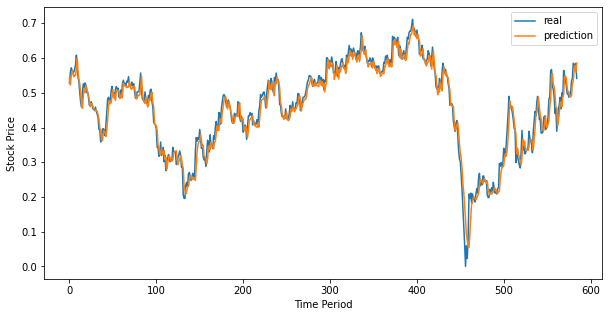

In [49]:
## 결과확인
prediction = model.predict(test_dataset)
plt.figure(figsize=(10,5))
plt.plot(testY)
plt.plot(prediction)
plt.xlabel("Time Period")
plt.ylabel("Stock Price")
plt.legend(['real', 'prediction'])
plt.show()

In [50]:
final_predict = prediction[-1]

In [51]:
final_predict

array([0.58545965], dtype=float32)

In [61]:
final_predict * (denom + 1e-7) + min

array([242579.17], dtype=float32)